In [1]:
import os
import numpy as np
import pandas as pd
import importlib
import ipywidgets as widgets
import datetime as dt

import stable_baselines3 as sb
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter

In [19]:
import cpagent
import cprender
import cpenvs
import cppid

_ = importlib.reload(cpagent)
_ = importlib.reload(cprender)
_ = importlib.reload(cpenvs)
_ = importlib.reload(cppid)

In [ ]:
dir = f"../data/{dt.datetime.now().strftime('%Y%m%dT%H%M%SZ')}-a2c-moving/"
print(dir)
os.makedirs(dir, exist_ok=True)

def env_maker():
    return cpenvs.MovingCartpoleEnv(use_normalized_state=True)
env = make_vec_env(env_maker, n_envs=8, vec_env_cls=SubprocVecEnv, monitor_dir=dir)

model = sb.A2C("MlpPolicy", env, verbose=0, tensorboard_log="./dqn_cartpole_tensorboard/")

model.learn(total_timesteps=200_000, log_interval=4, progress_bar=True)
model.save(dir+ "model_a2c_moving")

../data/20240310T134423Z-a2c-moving/


Output()

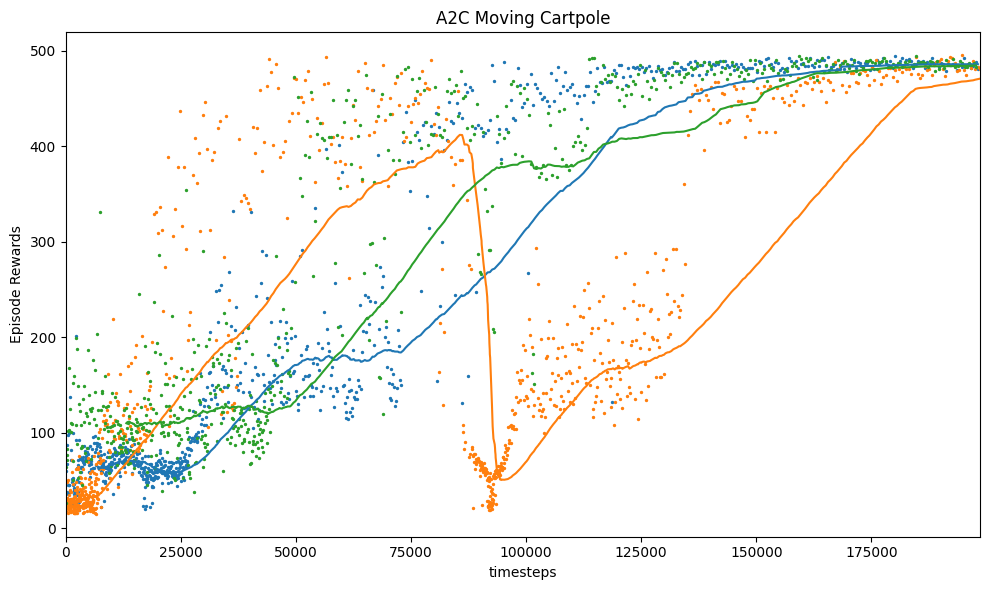

In [14]:
dir1 = "../data/20240310T133209Z-a2c-moving/"
dir2 = "../data/20240310T134057Z-a2c-moving/"
dir3 = "../data/20240310T134423Z-a2c-moving/"

results_plotter.plot_results(
    [dir1, dir2, dir3],
    250_000,
    results_plotter.X_TIMESTEPS,
    "A2C Moving Cartpole",
    figsize=(10, 6)
)

In [21]:
model = sb.A2C.load(dir1+ "/model_a2c_moving")
agent = cpagent.ModelCartPoleAgent(model)

df = cpagent.execute_cartpole(agent, cpenvs.MovingCartpoleEnv(use_normalized_state=True), num_episodes=100)
df

,ep,t,cart_pos,cart_vel,pole_ang,pole_vel,pos_deviation,force,reward,cart_pos_setpoint
0,0,0,0.041010,0.016504,0.026166,-0.013754,0.041010,0.0,NaN,0.000000
1,0,1,0.041340,0.211241,0.025891,-0.298068,0.041340,10.0,0.999146,0.000000
2,0,2,0.045565,0.015760,0.019930,0.002666,0.045565,-10.0,0.998962,0.000000
3,0,3,0.045880,0.210590,0.019983,-0.283662,0.045880,10.0,0.998948,0.000000
4,0,4,0.050092,0.015189,0.014310,0.015255,0.050092,-10.0,0.998745,0.000000
...,...,...,...,...,...,...,...,...,...,...
50095,99,496,-0.576391,-0.030650,0.004482,0.048257,0.137702,10.0,0.990519,-0.714093
50096,99,497,-0.577004,0.164407,0.005447,-0.243008,0.137089,10.0,0.990603,-0.714093
50097,99,498,-0.573716,-0.030792,0.000587,0.051388,0.140377,-10.0,0.990147,-0.714093
50098,99,499,-0.574332,0.164322,0.001615,-0.241110,0.139761,10.0,0.990233,-0.714093


In [20]:
#df.groupby("ep")["reward"].sum().to_frame("ep_reward").sort_values(by="ep_reward")
#df.groupby("ep")["pole_ang"].min().to_frame("maxangle").sort_values(by="maxangle")

In [22]:
_ = widgets.interact(
    lambda ep, t: cprender.render_cartpole_state_df(df, t, ep),
    ep=widgets.IntSlider(min=0, max=20, step=1, value=0),
    t=widgets.IntSlider(min=0, max=500, step=1, value=0),
)

interactive(children=(IntSlider(value=0, description='ep', max=20), IntSlider(value=0, description='t', max=50…

In [23]:
EP = 0

fig = cprender.lineplot(df, ep=EP, incl_velo=False)
fig.show()

In [25]:
agent_ref = cppid.PidAgentMoving2(
    (0.301, 0.0190, 0.0797),
    (0.0659, 0.00, 0.0499),
    1.33
)
df_ref = cpagent.execute_cartpole(agent_ref, env=cpenvs.MovingCartpoleEnv(), num_episodes=100)
df_ref

,ep,t,cart_pos,cart_vel,pole_ang,pole_vel,pos_deviation,force,reward,cart_pos_setpoint
0,0,0,-0.015430,0.019506,0.009300,-0.038716,-0.015430,0.0,NaN,0.000000
1,0,1,-0.015040,-0.175748,0.008526,0.256886,-0.015040,-10.0,0.999887,0.000000
2,0,2,-0.018555,-0.370991,0.013663,0.552246,-0.018555,-10.0,0.999828,0.000000
3,0,3,-0.025975,-0.176064,0.024708,0.263899,-0.025975,10.0,0.999663,0.000000
4,0,4,-0.029496,0.018697,0.029986,-0.020889,-0.029496,10.0,0.999565,0.000000
...,...,...,...,...,...,...,...,...,...,...
50095,99,496,0.796543,0.003776,0.008287,0.016789,0.003864,10.0,0.999993,0.792679
50096,99,497,0.796619,0.198778,0.008623,-0.273268,0.003940,10.0,0.999992,0.792679
50097,99,498,0.800594,0.393776,0.003157,-0.563219,0.007916,10.0,0.999969,0.792679
50098,99,499,0.808470,0.198610,-0.008107,-0.269543,0.015791,-10.0,0.999875,0.792679


[(450.0, 500.0)]

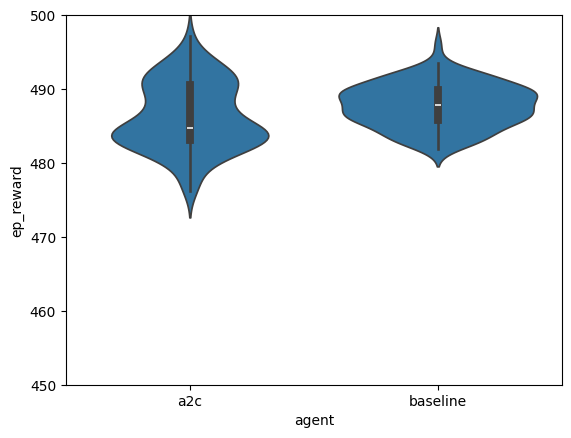

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as maxes


dfplt = df.groupby("ep")["reward"].sum().to_frame("ep_reward")
dfplt["agent"] = "a2c"

dfplt_ref = df_ref.groupby("ep")["reward"].sum().to_frame("ep_reward")
dfplt_ref["agent"] = "baseline"

dfplt = pd.concat([dfplt, dfplt_ref])

fig, ax = plt.subplots()
ax:maxes.Axes = ax

sns.violinplot(
    dfplt,
    x="agent",
    y="ep_reward",
    orient="v",
    ax=ax
)

ax.set(ylim=(450.0, 500.0))